## Data

Job offers - I want to find words and ofers similar to 'Machine Learning Engineer' & 'Data scientist' (: using job offers titles.

In [1]:
import pandas as pd

from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora import Dictionary

from gensim.models import Word2Vec, LdaMulticore

from ast import literal_eval

import pyLDAvis
from pyLDAvis import gensim

pyLDAvis.enable_notebook()

In [2]:
df = pd.read_csv('data/job_ofer.csv')
df.head()

,title,company_name,address,description,seniority_level,employment_type,job_function,industries
0,Machine Learning Engineer,Intellipro Group Inc,"Palo Alto, CA, US","['About The Company', ""W*** is reshaping the f...",Entry level,Full-time,Engineering,Information Technology and Services
1,Deep Learning Applied Researcher - Chicago,Ethosia,"Chicago, IL, US","['תיאור המשרה', 'Deep learning for Computer Vi...",Associate,Full-time,Other,Information Technology and Services
2,Machine Learning Engineer,Motorola Solutions,"Chicago, IL, US","['Company Overview', 'At Motorola Solutions, w...",Entry level,Full-time,Engineering,Information Technology and Services
3,Machine Learning / Data Scientist,Proprius LLC,"San Francisco, CA, US",['Our client is a digital invention agency foc...,Entry level,Full-time,Engineering,Information Technology and Services
4,Cloud Architect,TCS,"Framingham, Massachusetts, United States","['Technical/Functional Skills', ' ', 'Good to ...",Mid-Senior level,Full-time,Engineering,Information Technology and Services


In [3]:
df.shape

(36109, 8)

In [4]:
df.description[0]

'[\'About The Company\', "W*** is reshaping the future of delivery. We are an on-demand drone delivery service that can deliver food, medicine or other items within minutes. We\'ve also developed an unmanned traffic management platform to safely route drones through the sky. Our service is faster, safer and produces far less pollution than traditional delivery.", \'About The Role\', \'As a Machine Learning Engineer you will help develop models to support the next generation of intelligence that backs our flight planning and navigation solutions. In this way, you will play an important part in our larger goal of building a state-of-the-art delivery system that safely flies thousands of autonomous aircraft every day around people, buildings, and terrain, with or without GPS, day or night, rain or shine. Developing machine-learning-based models with the real world application in mind is a difficult problem, but working at the intersection of R&D and production is a unique and exhilarating

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36109 entries, 0 to 36108
Data columns (total 8 columns):
title              36109 non-null object
company_name       33925 non-null object
address            36109 non-null object
description        36109 non-null object
seniority_level    36109 non-null object
employment_type    36109 non-null object
job_function       36099 non-null object
industries         36095 non-null object
dtypes: object(8)
memory usage: 2.2+ MB


In [6]:
df.isnull().sum()

title                 0
company_name       2184
address               0
description           0
seniority_level       0
employment_type       0
job_function         10
industries           14
dtype: int64

There are no missing values in titles.

## Word2Vec - finding most similar words (in titles).

Making **corpus from title** column & **simple preprocess** & **remooving stopwords**.

In [7]:
stop = [ word for word in STOPWORDS if word not in ['it', 'full'] ] 
# probably 'it analyst' or 'full stack developer' could be usefull for someone

stop[:8]

['own', 'everyone', 'give', 'seem', 'since', 'system', 'mostly', 'bottom']

In [8]:
title_corpus = df['title'].map( simple_preprocess )

In [9]:
title_corpus[36086]

['it', 'analyst', 'web', 'and', 'mobile', 'developer']

In [10]:
title_corpus = title_corpus.apply(lambda x: [x for x in x if x not in stop])

In [11]:
title_corpus[36086]

['it', 'analyst', 'web', 'mobile', 'developer']

**Bigram**

In [12]:
title_bigram =  Phrases( title_corpus, min_count = 3, threshold = 3 ) 

In [13]:
list(title_corpus[:5])

[['machine', 'learning', 'engineer'],
 ['deep', 'learning', 'applied', 'researcher', 'chicago'],
 ['machine', 'learning', 'engineer'],
 ['machine', 'learning', 'data', 'scientist'],
 ['cloud', 'architect']]

In [14]:
list(title_bigram[title_corpus])[:5]

[['machine_learning', 'engineer'],
 ['deep_learning', 'applied', 'researcher', 'chicago'],
 ['machine_learning', 'engineer'],
 ['machine_learning', 'data_scientist'],
 ['cloud', 'architect']]

In [15]:
list(title_bigram.vocab.keys())[:20]

[b'machine',
 b'learning',
 b'machine_learning',
 b'engineer',
 b'learning_engineer',
 b'deep',
 b'deep_learning',
 b'applied',
 b'learning_applied',
 b'researcher',
 b'applied_researcher',
 b'chicago',
 b'researcher_chicago',
 b'data',
 b'learning_data',
 b'scientist',
 b'data_scientist',
 b'cloud',
 b'architect',
 b'cloud_architect']

Counting the number of two-word phrases (bigram).

In [16]:
from collections import Counter

In [17]:
bigram_counter = Counter()
for key in title_bigram.vocab.keys():
    if len(key.decode('utf-8').split("_")) > 1:
        bigram_counter[key] += title_bigram.vocab[key]

for key, counts in bigram_counter.most_common(20):
    print ('{0}  {1}'.format(key.decode("utf-8"), counts))

relocate_china  3847
new_york  2722
san_francisco  2306
account_executive  818
china_relocate  668
beijing_relocate  593
editor_relocate  591
project_manager  561
copy_editor  528
manager_new  457
product_manager  434
software_engineer  421
business_development  418
data_scientist  376
senior_account  354
public_school  354
manager_san  350
shenzhen_relocate  347
account_manager  344
francisco_ca  325


Probably 'machine_learning' is not very popular in job offers titles (; but 'data_scientist' phrase appears in 14th place (counting the number of occurrences).

Applaying bigram (two word phrases) to corpus.

In [18]:
def prepare_corpus( corpus, bigram ):
    for sent in corpus:
        yield bigram[sent] + sent 

In [19]:
title_bigram_pr = Phraser( Phrases( title_corpus, min_count = 3, threshold = 3 ) )

In [20]:
title_ext_corp = list( prepare_corpus( title_corpus, title_bigram_pr ) )

title_model = Word2Vec( title_ext_corp, size = 100, window = 5, min_count = 3 )

Checking some **most similar** words based on title to compare it later with **doc2vec**.

In [21]:
title_model.wv.most_similar('data_scientist')

[('scientist', 0.9743682146072388),
 ('medicinal', 0.958753764629364),
 ('applied_scientist', 0.9317528009414673),
 ('healthcare_asset', 0.9309884309768677),
 ('ml', 0.9305295348167419),
 ('lead_mdg', 0.9194098114967346),
 ('nlp', 0.9176998734474182),
 ('decision', 0.9132744669914246),
 ('hydrologist', 0.912851095199585),
 ('deep_learning', 0.9112963080406189)]

In [22]:
title_model.wv.most_similar('machine')

[('machine_learning', 0.9586498737335205),
 ('vision', 0.927213191986084),
 ('self_driving', 0.9204632043838501),
 ('nlp', 0.9170708060264587),
 ('processing_nlp', 0.9133612513542175),
 ('deep_learning', 0.9091371297836304),
 ('learning', 0.9057248830795288),
 ('natural_language', 0.8998712301254272),
 ('deep', 0.8990533351898193),
 ('algorithm', 0.8817200064659119)]

In [23]:
title_model.wv.most_similar('machine_learning')

[('nlp', 0.9600147604942322),
 ('machine', 0.9586498737335205),
 ('deep_learning', 0.955106794834137),
 ('learning', 0.9496459364891052),
 ('self_driving', 0.9448155164718628),
 ('deep', 0.944733738899231),
 ('ml', 0.9377524852752686),
 ('vision', 0.9369229674339294),
 ('processing_nlp', 0.9313145875930786),
 ('artificial_intelligence', 0.9301176071166992)]

In [24]:
title_model.wv.most_similar('nlp')

[('deep_learning', 0.9892052412033081),
 ('deep', 0.9768012762069702),
 ('vision', 0.9726219177246094),
 ('artificial_intelligence', 0.9654704332351685),
 ('big_data', 0.9648470878601074),
 ('medicinal', 0.962134599685669),
 ('ml', 0.9619052410125732),
 ('applied_scientist', 0.9609413146972656),
 ('machine_learning', 0.9600147008895874),
 ('natural_language', 0.9558699727058411)]

### Most similar words based on Description - **Word2vec**

In [25]:
df.sample()['description'].values[0] 

'[\'Hello! We are jones knowles ritchie\', "We\'re an award-winning and proudly independent creative branding agency with offices in London, New York, Singapore, and Shanghai. We grow businesses by creating unmistakable brand stories that come to life through design, film, brand experiences, and beyond. We work for some of the most famous brands in the world, amplifying and celebrating what makes them unique to help them get noticed and chosen", \'About You Two\', \'We are looking to bring on board an established creative team of Art Director and Copywriter. You are senior ideas people, a dynamic team who can create big ideas and bring them to life. Through your own graphic design work and art direction and copy skills, you can capture the spirit of an idea in a wide variety of aesthetic styles. From print, apparel, key visuals, campaigns, to video and motion, your work exhibits thinking, quality and visual diversity. This role is responsible for leading concept development and the tra

In [65]:
for line in df.sample()['description'].map(literal_eval).values[0]:
    print(line)
    print("")

First Quantum Minerals Ltd. has grown from a small mineral operation in Zambia into a multinational mining business in less than two decades, with a global portfolio of copper and nickel assets in Europe, Africa, Australia and South America. This phenomenal growth is down to FQM people who have strived to be Bolder, Smarter and Driven in everything they do. In March 2013, First Quantum Minerals acquired Inmet Mining Corporation, a Canadian-based mining company primarily producing copper and zinc from mines in Finland, Spain and Turkey, with also a major copper deposit under development in Panama, known as Cobre Panama. The combination of the First Quantum and Inmet assets has created one of the world’s leading copper producers with a geographically diversified portfolio of high-quality operations and development projects in eight countries across five continents. With a strategic plan to produce more than 1 million tonnes per annum of copper within five years, the Company is poised to 

In [28]:
descr_corpus = df['description'].map( simple_preprocess ) 

descr_bigram = Phraser( Phrases( descr_corpus, min_count = 3, threshold = 3 ) ) 

In [29]:
descr_ext_corp = list( prepare_corpus( descr_corpus, descr_bigram ) )
len(descr_ext_corp)

36109

In [31]:
descr_model = Word2Vec( descr_ext_corp, size = 100, window = 2, min_count = 1 ) 

**most similar**

In [32]:
descr_model.wv.most_similar('machine')

[('usesmachine', 0.5719109773635864),
 ('statistics_machine', 0.563867449760437),
 ('nlp_machine', 0.5527011156082153),
 ('ai_machine', 0.5522999167442322),
 ('algorithms', 0.5481206178665161),
 ('natural_language', 0.5452167987823486),
 ('deploy_machine', 0.5429693460464478),
 ('trees_deep', 0.5368468761444092),
 ('ml', 0.534711480140686),
 ('reinforcement', 0.5330970287322998)]

In [33]:
descr_model.wv.most_similar('machine_learning')

[('deep_learning', 0.8372340798377991),
 ('computer_vision', 0.8061434030532837),
 ('advanced_analytics', 0.7653337717056274),
 ('big_data', 0.753031849861145),
 ('data_science', 0.7449259757995605),
 ('artificial_intelligence', 0.7288526296615601),
 ('ml', 0.7263628244400024),
 ('nlp', 0.7043582201004028),
 ('data_mining', 0.7007495164871216),
 ('algorithms', 0.6961237192153931)]

In [34]:
descr_model.wv.most_similar('pytorch') 

[('tensorflow', 0.9220554828643799),
 ('scikit_learn', 0.9214270114898682),
 ('keras', 0.9132823944091797),
 ('mxnet', 0.9112928509712219),
 ('numpy', 0.9076200723648071),
 ('caffe', 0.8983209133148193),
 ('scipy', 0.8859615921974182),
 ('nltk', 0.8847887516021729),
 ('theano', 0.8772544860839844),
 ('pandas', 0.8738015294075012)]

OK :). For most similar in title_model 'pytorch' was even not in vocabulary.

## Topic modelling

Topic modelling on extended corpus made from titles.

In [35]:
dictionary = Dictionary(title_ext_corp)

First 10 pairs of a dict (as an example):

In [63]:
first10pairs = {k: dict(dictionary)[k] for k in list(dict(dictionary))[:10]}
first10pairs

{0: 'engineer',
 1: 'learning',
 2: 'machine',
 3: 'machine_learning',
 4: 'applied',
 5: 'chicago',
 6: 'deep',
 7: 'deep_learning',
 8: 'researcher',
 9: 'data'}

In [37]:
bow_corpus = [ dictionary.doc2bow(sent) for sent in title_ext_corp ]

In [38]:
bow_corpus[:10]

[[(0, 2), (1, 1), (2, 1), (3, 1)],
 [(1, 1), (4, 2), (5, 2), (6, 1), (7, 1), (8, 2)],
 [(0, 2), (1, 1), (2, 1), (3, 1)],
 [(1, 1), (2, 1), (3, 1), (9, 1), (10, 1), (11, 1)],
 [(12, 2), (13, 2)],
 [(9, 1), (10, 1), (11, 1)],
 [(14, 2), (15, 2), (16, 2)],
 [(17, 2), (18, 2)],
 [(19, 2), (20, 2), (21, 2), (22, 2), (23, 2), (24, 2)],
 [(0, 2), (25, 2), (26, 2), (27, 2), (28, 2)]]

In [39]:
lda_model = LdaMulticore(bow_corpus, id2word = dictionary, num_topics=100, passes = 20, workers = 20)

In [70]:
%time lda_vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)

C:\Users\maw\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Wall time: 2min 32s


In [59]:
pyLDAvis.display(lda_vis)

Because the topic modeling chart does not load on Github with the notebook, below is **screen** (parameters cannot be changed)

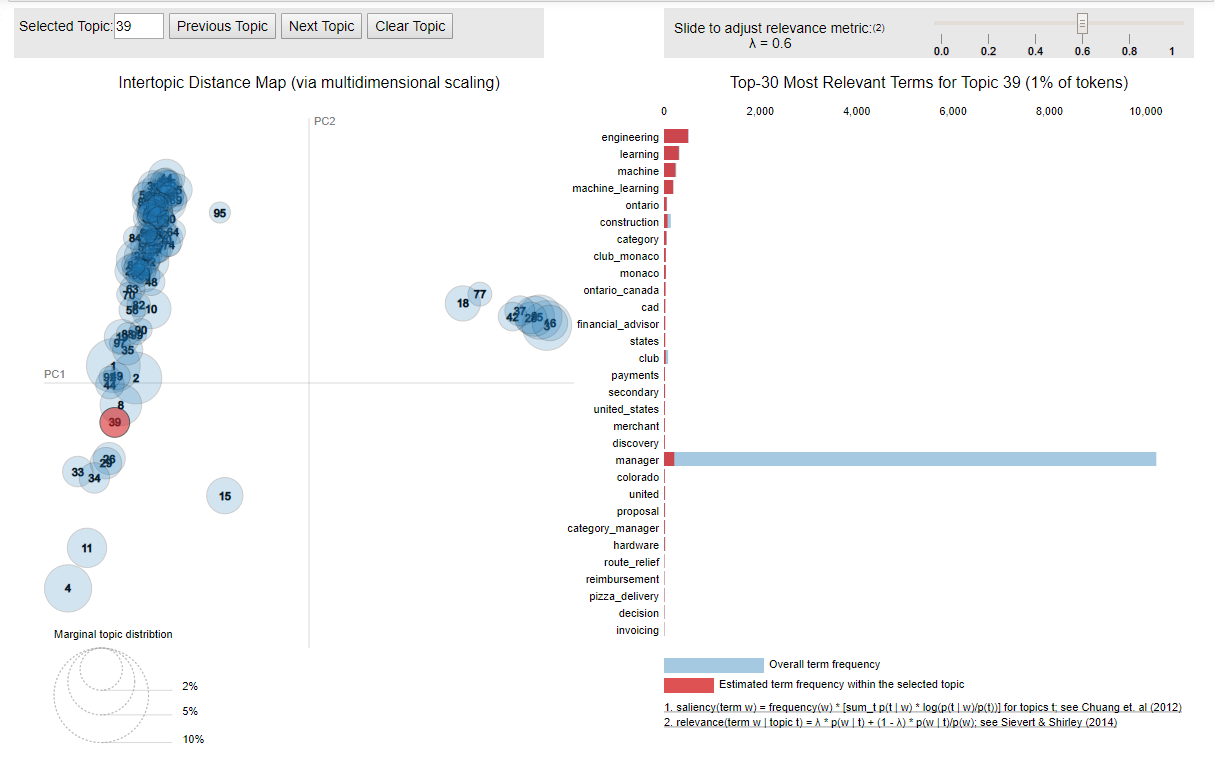

In [40]:
for idx, topic in lda_model.print_topics(-1)[:12]:
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.268*"project" + 0.173*"manager" + 0.131*"project_manager" + 0.054*"senior" + 0.037*"south" + 0.034*"training" + 0.030*"francisco" + 0.026*"south_san" + 0.022*"san" + 0.020*"engineer"
Topic: 1 
Words: 0.145*"regional" + 0.107*"manager" + 0.068*"administrator" + 0.044*"detective" + 0.043*"supply" + 0.035*"usa" + 0.033*"chain" + 0.030*"prevention" + 0.030*"supply_chain" + 0.029*"loss"
Topic: 2 
Words: 0.228*"management" + 0.146*"china" + 0.123*"international" + 0.101*"trainee" + 0.070*"relocate" + 0.070*"international_management" + 0.070*"trainee_relocate" + 0.015*"vision" + 0.014*"hourly" + 0.014*"distribution"
Topic: 3 
Words: 0.093*"global" + 0.091*"leader" + 0.055*"associate" + 0.045*"product" + 0.042*"nh" + 0.042*"based" + 0.041*"bangkok_based" + 0.041*"bangkok" + 0.031*"manager" + 0.026*"innovation"
Topic: 4 
Words: 0.334*"product" + 0.219*"manager" + 0.054*"senior" + 0.050*"team" + 0.050*"general" + 0.022*"member" + 0.021*"team_member" + 0.019*"tn" + 0.017*"canad

## doc2vec

In [41]:
import numpy as np

from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

**title_corpus was already prepared in Word2vec part**. (simple preprocess + stopwords removed ) 

In [42]:
title_corpus[:6]

0                     [machine, learning, engineer]
1    [deep, learning, applied, researcher, chicago]
2                     [machine, learning, engineer]
3              [machine, learning, data, scientist]
4                                [cloud, architect]
5                                 [data, scientist]
Name: title, dtype: object

In [43]:
len(title_corpus)

36109

Assigning an id to each word list using a TaggedDocument.

In [44]:
title_tagged = [TaggedDocument(words = sent, tags = [i]) for i, sent in enumerate(title_corpus)]

In [45]:
title_tagged[:5]

[TaggedDocument(words=['machine', 'learning', 'engineer'], tags=[0]),
 TaggedDocument(words=['deep', 'learning', 'applied', 'researcher', 'chicago'], tags=[1]),
 TaggedDocument(words=['machine', 'learning', 'engineer'], tags=[2]),
 TaggedDocument(words=['machine', 'learning', 'data', 'scientist'], tags=[3]),
 TaggedDocument(words=['cloud', 'architect'], tags=[4])]

In [46]:
title_model = Doc2Vec(vector_size = 300, window_size = 5, min_count = 1)
title_model.build_vocab(title_tagged)

In [47]:
title_model.train(title_tagged, total_examples=title_model.corpus_count, epochs=10)

In [48]:
m_sim = title_model.docvecs.most_similar(0)
m_sim

[(32357, 0.8367736339569092),
 (324, 0.8078400492668152),
 (15292, 0.8031727075576782),
 (31954, 0.7954121232032776),
 (27487, 0.7903189659118652),
 (6027, 0.788388192653656),
 (29206, 0.7807192802429199),
 (320, 0.7794485092163086),
 (7292, 0.7790466547012329),
 (15294, 0.7786332368850708)]

In [49]:
idx_similar = np.array(m_sim)[:,0] 
idx_similar

array([32357.,   324., 15292., 31954., 27487.,  6027., 29206.,   320.,
        7292., 15294.])

**Finfing most similar titles without bigram**.

I`m looking for most similar titles to 'Machine Learning Engineer'.

In [50]:
df[ df.index == 0 ].title

0    Machine Learning Engineer
Name: title, dtype: object

In [51]:
df.loc[idx_similar, 'title'].values 

array(['Senior Machine Learning Engineer - Natural Language Processing (NLP)',
       'Machine Learning Researcher',
       'Machine Shop Manufacturing Process Improvement Engineer',
       'Machine Operator', 'Assemblers and Machine Operators',
       'Fabrication Machine Operator II - Camas',
       'Assemblers and Machine Operators',
       'Data Science and Machine Learning Researcher',
       'Fabrication Machine Operator II - Camas',
       'Machine Shop Manufacturing Process Improvement Engineer'],
      dtype=object)

The model does not perform well without bigram fhrases.

**Using extended titled corpus (with bigram)**

The title_ext_corp was prepared in the word2vec part.

In [52]:
title_ext_corp[:5]

[['machine_learning', 'engineer', 'machine', 'learning', 'engineer'],
 ['deep_learning',
  'applied',
  'researcher',
  'chicago',
  'deep',
  'learning',
  'applied',
  'researcher',
  'chicago'],
 ['machine_learning', 'engineer', 'machine', 'learning', 'engineer'],
 ['machine_learning',
  'data_scientist',
  'machine',
  'learning',
  'data',
  'scientist'],
 ['cloud', 'architect', 'cloud', 'architect']]

In [71]:
len(title_ext_corp)

36109

In [53]:
title_tagged_big = [TaggedDocument(words = sent, tags = [i]) for i, sent in enumerate(title_ext_corp)]

In [72]:
title_model_big = Doc2Vec(vector_size = 300, window_size = 5, min_count = 1)
title_model_big.build_vocab(title_tagged_big)

In [73]:
title_model_big.train(title_tagged_big, total_examples=title_model.corpus_count, epochs=10)

Finding most similar to 'Machine learning Enginner' at index 0 in the DataFrame.

In [67]:
df[ df.index == 0 ].title

0    Machine Learning Engineer
Name: title, dtype: object

In [75]:
m_sim = title_model_big.docvecs.most_similar(0)
idx_similar_big = np.array(m_sim)[:,0] 
df.loc[idx_similar_big, 'title'].values 

array(['Vertriebsmitarbeiter für Heizungs-, Lüftungs- und Klimatechnik (m/w/d)',
       'CDL A Owner Operators - Flatbed, Dry Van, & Reefer Available',
       'TOP PRAXIS aus Niedersachsen im PLZ Gebiet 38 ... sucht einen Facharzt Radiologie (m/w) - Festanstellung - Top Gehalt - flex. Arbeitszeiten und ein tolles Team',
       "Komm' zu uns als Schulbegleiter (m/w/d) für das Gebiet Fürstenfeldbruck",
       'Gärtner (m/w/d) im Garten- und Landschaftsbau',
       'Machine Operators & Assemblers',
       'TOP KLINIKUM / Großstadt in Baden-Württemberg / PLZ 7 ... sucht einen Oberarzt im Bereich Mund-, Kiefer- und Gesichtschirurgie (m/w)',
       'Referenten (m/w/d) für die Stabsstelle Innovation und Digita',
       'Assemblers and Machine Operators',
       'CDL-A OTR Driving Jobs - 2 Years Exp Required - Avg $75k/Yea'],
      dtype=object)

It is not working well right now. Currently I`m checking why, because it was performing quite well earlyier :). **Please check for updates in few days.**